In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

In [2]:
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# EDA

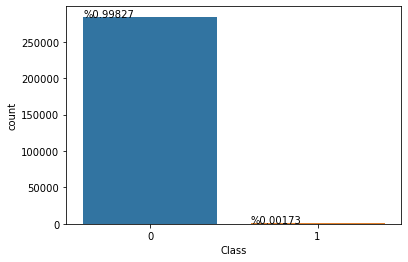

In [4]:
ax=sns.countplot(x='Class', data=df)

for p in ax.patches:
        ax.annotate('%{:.5f}'.format(p.get_height()/284807), (p.get_x(), p.get_height()))

<AxesSubplot:ylabel='Frequency'>

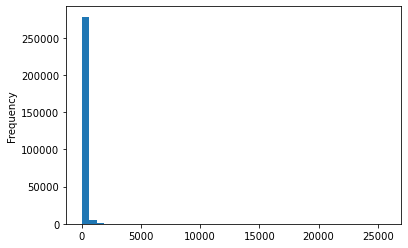

In [5]:
df['Amount'].plot.hist(bins=40)

<AxesSubplot:xlabel='Class', ylabel='Amount'>

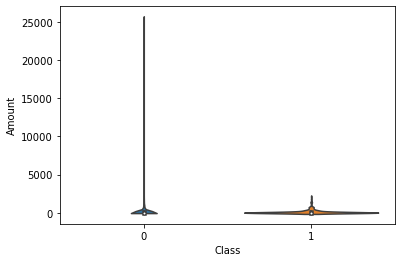

In [6]:
sns.violinplot(x = 'Class', y = 'Amount', data = df)

Logarithm Scaling

In [7]:
df2=df.copy()
df2['AmountLog'] = np.log1p(df2['Amount'])

<AxesSubplot:ylabel='Frequency'>

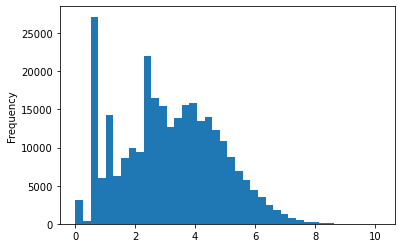

In [8]:
df2['AmountLog'].plot.hist(bins=40)

<AxesSubplot:xlabel='Class', ylabel='AmountLog'>

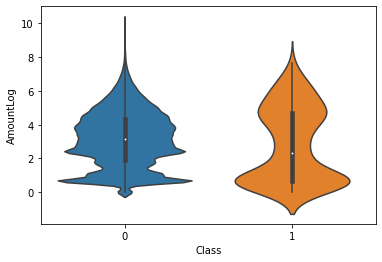

In [9]:
sns.violinplot(x = 'Class', y = 'AmountLog', data = df2)

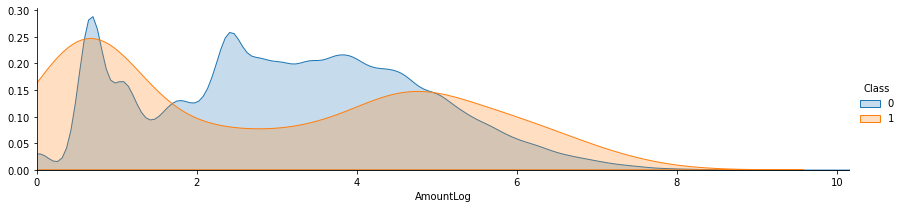

In [10]:
facet = sns.FacetGrid(df2, hue="Class",aspect=4)
facet.map(sns.kdeplot,'AmountLog',shade= True)
facet.set(xlim=(0, df2['AmountLog'].max()))
facet.add_legend()

Text(0.5, 1, 'Corrolation between Variables')

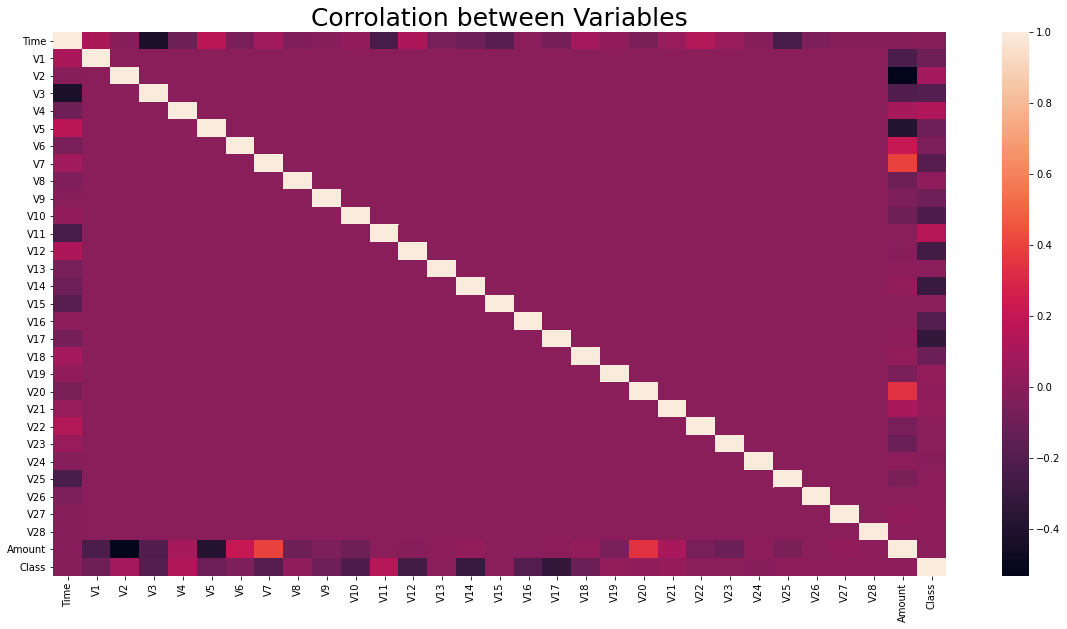

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())
plt.title('Corrolation between Variables',y=1, size=25)

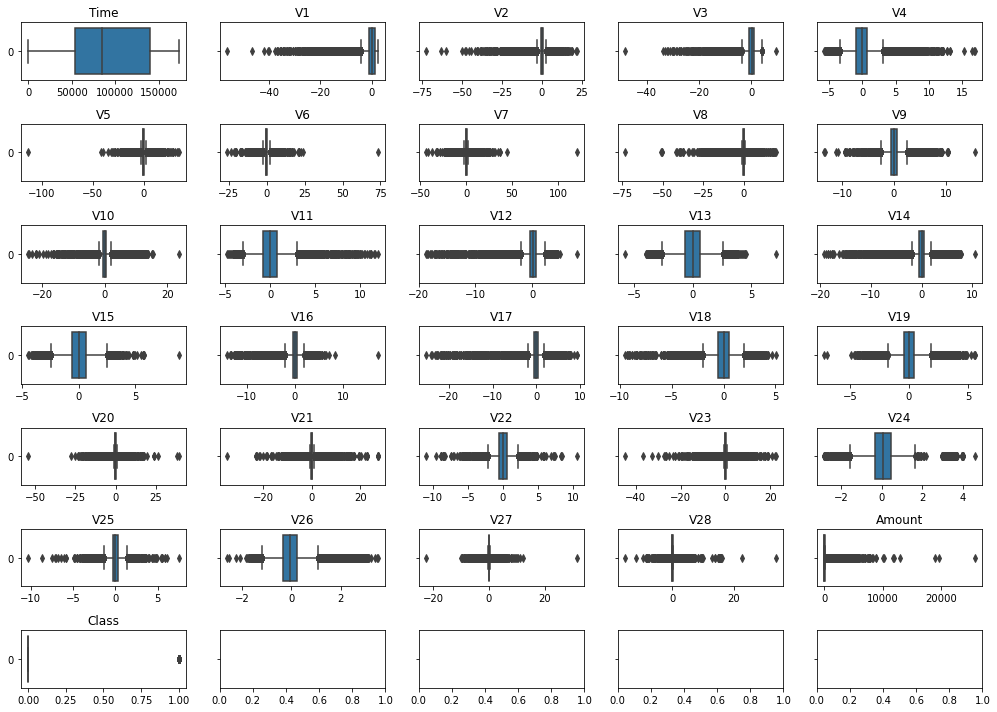

In [12]:
fig, axs = plt.subplots(7, 5, sharey=True, figsize=(14,10))
axs = axs.flatten()
for i, col in enumerate(df.columns):
    sns.boxplot(data=df[col], orient='h', ax=axs[i])
    axs[i].set_title(col)
        
plt.tight_layout()

In [13]:
outlier_list = []
    
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_index = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))].index 
    outlier_list.extend(outlier_index)
    
print('amount of outliers:')
print(len(set(outlier_list)))

amount of outliers:
138488


In [14]:
df3=df.drop(index=set(outlier_list))
df3['Class'].value_counts() #Dataset after delete outliers

0    146319
Name: Class, dtype: int64

In [15]:
df['Class'].value_counts() #Original dataset

0    284315
1       492
Name: Class, dtype: int64

no more fraud data after outliers are canceled. So we don't delete outliers.

# Baseline

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import sklearn.model_selection as cv

Split Test/ Train Data

In [17]:
x1=df.drop(columns=['Class'])
y1= df['Class']
train_x, test_x, train_y, test_y = cv.train_test_split(x1,y1,train_size=0.8, test_size=0.2,random_state = 42)

In [18]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(train_x,train_y)
y_pred_random_forest=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('Baseline Accuracy:{}%'.format(acc_random_forest))

Baseline Accuracy:99.96%


In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, y_pred_random_forest)
print(cm)

#True Negative    False Positive
#False Negative   True Positive

[[56861     3]
 [   22    76]]


In [20]:
from sklearn.metrics import recall_score, precision_score, f1_score

Recall_socre = recall_score(test_y, y_pred_random_forest)                      #Recall=TP/(TP+FN)
print("Baseline Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_random_forest)                #Precision=TP/(TP+FP)
print("Baseline Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_random_forest)                              #F1=(2*Precision*Recall)/(Precision+Recall)
print("SMOTE F score: {}".format(round(F1_score, 2)))

round(F1_score, 2)

Baseline Recall score: 77.55%
Baseline Precision score: 96.2%
SMOTE F score: 0.86


0.86

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(clf, train_x, train_y, cv=kf, scoring='recall')

print("Baseline CV Recall scores: {}".format(score))
print("Baseline Average CV Recall score: {}".format(score.mean()))

Baseline CV Recall scores: [0.79487179 0.69620253 0.72151899 0.78481013 0.82278481]
Baseline Average CV Recall score: 0.7640376501135995


# Oversampling - SMOTE

In [22]:
#!pip install imblearn

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
smote_train_x, smote_train_y = sm.fit_resample(train_x, train_y.ravel())

In [24]:
print("Before oversampling, counts fruad: {}".format(sum(train_y == 1)))
print("Before oversampling, counts non fruad: {} \n".format(sum(train_y == 0)))

print("After oversampling, counts of fruad: {}".format(sum(smote_train_y == 1)))
print("After oversampling, counts of non fruad: {}".format(sum(smote_train_y == 0)))

Before oversampling, counts fruad: 394
Before oversampling, counts non fruad: 227451 

After oversampling, counts of fruad: 227451
After oversampling, counts of non fruad: 227451


In [25]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(smote_train_x,smote_train_y)
y_pred_smote=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('SMOTE Accuracy:{}%'.format(acc_random_forest))

SMOTE Accuracy:99.96%


In [26]:
cm = confusion_matrix(test_y, y_pred_smote)
print(cm)

[[56853    11]
 [   14    84]]


In [27]:
Recall_socre = recall_score(test_y, y_pred_smote)
print("SMOTE Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_smote)
print("SMOTE Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_smote)
print("SMOTE F score: {}".format(round(F1_score, 2)))

SMOTE Recall score: 85.71%
SMOTE Precision score: 88.42%
SMOTE F score: 0.87


# Undersampling - Tomek

In [42]:
from imblearn.under_sampling import TomekLinks

undersample = TomekLinks()
tomek_train_x, tomek_train_y = undersample.fit_resample(train_x, train_y)

In [43]:
print("Before undersampling, counts fruad: {}".format(sum(train_y == 1)))
print("Before undersampling, counts non fruad: {} \n".format(sum(train_y == 0)))

print("After undersampling, counts of fruad: {}".format(sum(tomek_train_y == 1)))
print("After undersampling, counts of non fruad: {}".format(sum(tomek_train_y == 0)))

Before undersampling, counts fruad: 394
Before undersampling, counts non fruad: 227451 

After undersampling, counts of fruad: 394
After undersampling, counts of non fruad: 227387


In [44]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(tomek_train_x,tomek_train_y)
y_pred_tomek=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('Tomek Accuracy:{}%'.format(acc_random_forest))

Tomek Accuracy:99.96%


In [45]:
cm = confusion_matrix(test_y, y_pred_tomek)
print(cm)

[[56862     2]
 [   22    76]]


In [46]:
Recall_socre = recall_score(test_y, y_pred_tomek)
print("Tomek Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_tomek)
print("Tomek Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_tomek)
print("Tomek F score: {}".format(round(F1_score, 2)))

Tomek Recall score: 77.55%
Tomek Precision score: 97.44%
Tomek F score: 0.86


# SMOTE+Tomek

In [48]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek()
st_train_x, st_train_y = sm.fit_resample(train_x, train_y)

In [50]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(st_train_x,st_train_y)
y_pred_st=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('SMOTETomek Accuracy:{}%'.format(acc_random_forest))

SMOTETomek Accuracy:99.95%


In [51]:
cm = confusion_matrix(test_y, y_pred_st)
print(cm)

[[56851    13]
 [   16    82]]


In [52]:
Recall_socre = recall_score(test_y, y_pred_st)
print("SMOTETomek Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_st)
print("SMOTETomek Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_st)
print("SMOTETomek F score: {}".format(round(F1_score, 2)))

SMOTETomek Recall score: 83.67%
SMOTETomek Precision score: 86.32%
SMOTETomek F score: 0.85


# Random Oversampling and Undersampling

Random Oversampling

In [67]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2)

In [68]:
ros_train_x, ros_train_y = ros.fit_resample(train_x, train_y)

In [72]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(ros_train_x,ros_train_y)
y_pred_ros=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('Random Oversampling Accuracy:{}%'.format(acc_random_forest))

Random Oversampling Accuracy:99.96%


In [83]:
cm = confusion_matrix(test_y, y_pred_ros)
print(cm)

[[56863     1]
 [   22    76]]


In [73]:
Recall_socre = recall_score(test_y, y_pred_ros)
print("Random Oversampling Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_ros)
print("Random Oversampling Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_ros)
print("Random Oversampling F score: {}".format(round(F1_score, 2)))

Random Oversampling Recall score: 77.55%
Random Oversampling Precision score: 98.7%
Random Oversampling F score: 0.87


Random Undersampling

In [75]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2)

In [78]:
rus_train_x, rus_train_y = rus.fit_resample(train_x, train_y)

In [81]:
print("Before undersampling, counts fruad: {}".format(sum(train_y == 1)))
print("Before undersampling, counts non fruad: {} \n".format(sum(train_y == 0)))

print("After undersampling, counts of fruad: {}".format(sum(rus_train_y == 1)))
print("After undersampling, counts of non fruad: {}".format(sum(rus_train_y == 0)))

Before undersampling, counts fruad: 394
Before undersampling, counts non fruad: 227451 

After undersampling, counts of fruad: 394
After undersampling, counts of non fruad: 394


In [79]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(rus_train_x,rus_train_y)
y_pred_rus=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('Random Undersampling Accuracy:{}%'.format(acc_random_forest))

Random Undersampling Accuracy:97.62%


In [82]:
cm = confusion_matrix(test_y, y_pred_rus)
print(cm)

[[55516  1348]
 [    8    90]]


In [80]:
Recall_socre = recall_score(test_y, y_pred_rus)
print("Random Undersampling Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_rus)
print("Random Undersampling Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_rus)
print("Random Undersampling F score: {}".format(round(F1_score, 2)))

Random Undersampling Recall score: 91.84%
Random Undersampling Precision score: 6.26%
Random Undersampling F score: 0.12


# Change the weight/ panelty

In [53]:
clf = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")
#class_weight="balanced" means higher weight for elements that have smaller proportion 

In [54]:
clf.fit(train_x,train_y)
y_pred_weight=clf.predict(test_x)
acc_random_forest=round(clf.score(test_x,test_y)*100, 2)
print('Tomek Accuracy:{}%'.format(acc_random_forest))

Tomek Accuracy:99.96%


In [55]:
cm = confusion_matrix(test_y, y_pred_weight)
print(cm)

[[56863     1]
 [   23    75]]


In [56]:
Recall_socre = recall_score(test_y, y_pred_weight)
print("Balanced Class Weight Recall score: {}%".format(round(Recall_socre*100, 2)))

Precision_score = precision_score(test_y, y_pred_weight)
print("Balanced Class Weight Precision score: {}%".format(round(Precision_score*100, 2)))

F1_score = f1_score(test_y, y_pred_weight)
print("Balanced Class Weight F score: {}".format(round(F1_score, 2)))

Balanced Class Weight Recall score: 76.53%
Balanced Class Weight Precision score: 98.68%
Balanced Class Weight F score: 0.86


# Summary

In [85]:
df_compare = {
    'Method':['Baseline', 'SMOTE', 'Tomek', 'SMOTETomek', 'Balanced Class Weight', 'Random Oversampling', 'Random Undersampling'],
    'Recall':[77.55,85.71,77.55,83.67,76.53,77.55, 91.84],
    'Precision':[96.2,88.42,97.44,86.32,98.68,98.7, 6.26],
    'F1 Score':[0.86, 0.87,0.86,0.85,0.86,0.87, 0.12],
    'Accuracy':[99.96,99.96,99.96,99.95,99.96,99.96, 97.62]
}

In [86]:
pd.DataFrame(df_compare).sort_values(by=['Recall', 'Precision'], ascending=False)

,Method,Recall,Precision,F1 Score,Accuracy
6,Random Undersampling,91.84,6.26,0.12,97.62
1,SMOTE,85.71,88.42,0.87,99.96
3,SMOTETomek,83.67,86.32,0.85,99.95
5,Random Oversampling,77.55,98.70,0.87,99.96
2,Tomek,77.55,97.44,0.86,99.96
0,Baseline,77.55,96.20,0.86,99.96
4,Balanced Class Weight,76.53,98.68,0.86,99.96
